#**Práctica 2**
##Enunciado 3: Segmentación
En este ejercicio se nos pide que se resuelvamos un problema de segmentación de imágenes médicas: se trata de separar las células que aparecen en las imagenes del dataset, del fondo de esas mismas imágenes. El conjunto de datos contiene 50 imágenes, cada una separada en una carpeta diferente. Las dos imágenes que usaremos son las imágenes source.jpg y mask.jpg de cada carpeta. Es decir, el objetivo de esta práctica es construir un modelo que consiga discriminar que partes de la imagen de entrada son parte del fondo y cuales son células.

Para solucionar este problema de segmentación, se pide que como mínimo se avaluen 2 modelos diferentes: uno que tiene que estar creado por nosotros y otro que se base en una red ya existente. En nuestro caso, la red existente será la U-net, y la red creada por nosotros la comentaremos más adelante en profundidad.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import zipfile
import shutil
import os
import pandas as pd
import pathlib
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn

device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

Establecemos conexión con nuestra cuenta de google drive para cargar los datos que se encuentran ahí alojados.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Descomprimimos el archivo que contiene nuestros datos.

In [3]:
%cd /content/gdrive/MyDrive/AA/

/content/gdrive/MyDrive/AA


A continuacion definimos una función que nos permita normalizar nuestros datos en un rango de valores entre [0,1] y para ello haremos uso de los valores máximos y mínimos de las imágenes.

In [ ]:
!unzip Mabimi.zip;

A continuacion definimos una función que nos permita normalizar nuestros datos en un rango de valores entre [0,1] y para ello haremos uso de los valores máximos y mínimos de las imágenes.

In [ ]:
def normalize(image):
    # Obtener el valor mínimo y máximo de la imagen
    min = np.min(image)
    max = np.max(image)

    # Normalizar la imagen entre 0 y 1
    normalized_image = (image - min) / (max - min)

    return normalized_image

Nuestros modelos utilizan tamaños de imagenes de entrada distintos, por eso hemos definido dos transformaciones diferentes que simplemente nos redimensionarán el tamaño de las imagenes para que cada red pueda trabajar con ellas más adelante.

In [ ]:
# Definimos un conjunto de transformaciones para normalizar los datos y ajustarlos al tamaño adecuado
transformUNET = transforms.Compose([
    transforms.Resize((394, 394))
])
transformNet = transforms.Compose([
    transforms.Resize((608, 608))
])

Cargamos los paths tanto de las imagenes de source como de las mask, y comprobamos que efectivamente se han cargado las 50.

In [ ]:
Path = pathlib.Path('Mabimi/Mabimi/')
folders = [Path/i for i in os.listdir(Path)]
imgs=[]
masks=[]
for folder in folders:
  if folder != pathlib.PosixPath('Mabimi/Mabimi/.ipynb_checkpoints'):
    imgs.append(folder/'source.jpg')
    masks.append(folder/'mask.jpg')
len(masks),len(imgs)

(50, 50)

Para poder empezar a trabajar con nuestras redes, primero necesitamos realizar una serie de transformaciones sobre los datos. En nuestro caso necesitaremos pasar las imagenes source a tensores, los tensores son objetos matemáticos que almacenan valores numéricos y que pueden tener distintas dimensiones, y por otro lado, a la hora de entrenar nuestra red necesitaremos que las máscaras estén en formato one-hot encoding, en el que extenderemos cada pixel en una lista de longitud igual al número de clases (en este caso 2) con valores de 0 en todas las posiciones excepto en aquella que corresponda con la clase, dónde pondremos un 1. Para ilustrar un poco lo explicado anteriormente acerca del formato one-hot encoding adjuntamos la siguiente imagen. 

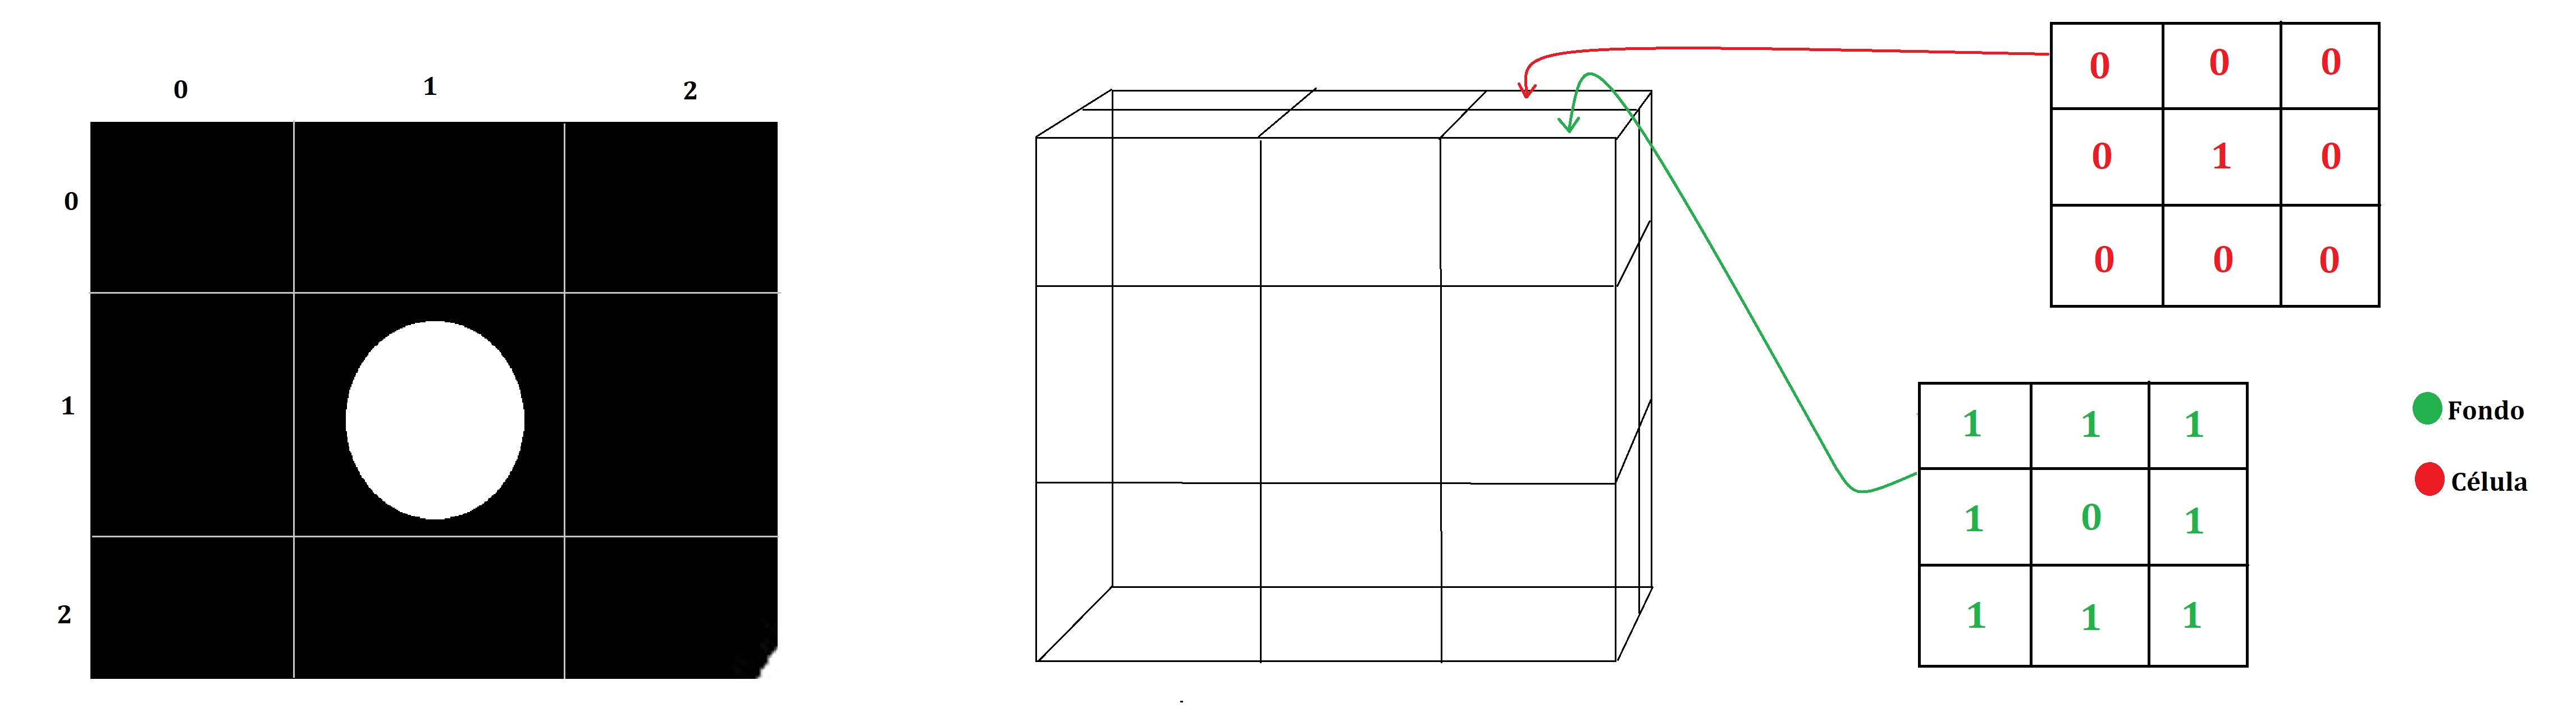

Evidentemente esto es una simplificación, pero del mismo modo que sucede aquí solo que a nivel de pixel, lo que tendremos será una matriz con dos dimensiones de profundidad, una para la clase "fondo" y otra para la clase "célula", y en cada posición de esas matrices tendremos un 1 o un 0 en función de si ese pixel se trata de un pixel del fondo o de la célula.

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, netName, n_classes=2):
    self.X = X
    self.y = y
    self.n_classes = n_classes
    self.netName = netName

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.netName == "UNET":
      transform = transformUNET
    else:
      transform = transformNet
    if self.y[ix] == pathlib.PosixPath('Mabimi/Mabimi/cell_14/mask.jpg'):
      transformGray = transforms.Grayscale(num_output_channels=1)
      mask = transformGray(Image.open(self.y[ix]))
      mask = transform(mask)
    else:
      mask = transform(Image.open(self.y[ix]))
    img = transform(Image.open(self.X[ix]))   
    img = normalize(np.array(img).astype(np.float32))
    img = torch.tensor(img)
    img = img.permute(2,0,1)
    mask = normalize(np.array(mask))
    mask = (np.arange(self.n_classes) == mask[...,None]).astype(np.float32)
    return img, torch.from_numpy(mask).permute(2,0,1)

Separamos el dataset un conjunto de entrenamiento ***train*** y un conjunto de test ***test***. Hemos dividido las 50 muestras en 40/10 respectivamente, es decir ***train*** contiene 40 muestras y ***test*** 10. Además como tenemos dos redes ,con transformaciones diferentes,cada una tendra sus propios conjuntos.

In [ ]:
datasetNet = {
    'train':  Dataset(imgs[:-10], masks[:-10],"NET"),
    'test':   Dataset(imgs[-10:], masks[-10:],"NET")
}

datasetUNET = {
    'train': Dataset(imgs[:-10], masks[:-10],"UNET"),
    'test':  Dataset(imgs[-10:], masks[-10:],"UNET")
}

Comprobamos que los tamaños son correctos

In [ ]:
len(datasetNet['train']), len(datasetNet['test'])

(40, 10)

In [ ]:
len(datasetUNET['train']), len(datasetUNET['test'])

(40, 10)

Ahora dividiremos cada conjunto en **batches** de 16, para esto utilizaremos la función [**DataLoader**](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader). Al igual que antes al tener dos redes pues habrá que guardar el  resultados por separado uno para cada red.


In [ ]:
batch_size=16
dataloaderUNET = {
    'train': torch.utils.data.DataLoader(datasetUNET['train'], batch_size, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(datasetUNET['test'], batch_size, pin_memory=True)
}

dataloaderNet = {
    'train': torch.utils.data.DataLoader(datasetNet['train'], batch_size, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(datasetNet['test'], batch_size, pin_memory=True)
}

Ahora iteraremos sobre los ***dataloaders*** anteriores y guardaremos cada iteracción en **imgs y masks**.


In [ ]:
imgsUNET, masksUNET = next(iter(dataloaderUNET['train']))
imgsUNET.shape, masksUNET.shape

(torch.Size([16, 3, 394, 394]), torch.Size([16, 2, 394, 394]))

In [ ]:
imgsNet, masksNet = next(iter(dataloaderNet['train']))
imgsNet.shape, masksNet.shape

(torch.Size([16, 3, 608, 608]), torch.Size([16, 2, 608, 608]))

# U-net
Para la implementación de la red U-net, nos hemos basado en un video tutorial que hemos encontrado en la plataforma Youtube, en el que se describe paso a paso y desde cero como programar dicha red. Nos ha parecido un [**video**](https://www.youtube.com/watch?v=5Qm2TQRtn9A.) muy interesante ya que la explicación es muy detallada y fácil de seguir.
Para facilitar la comprensión del código y del funcionamiento de la red aquí tenemos una imagen de su arquitectura.

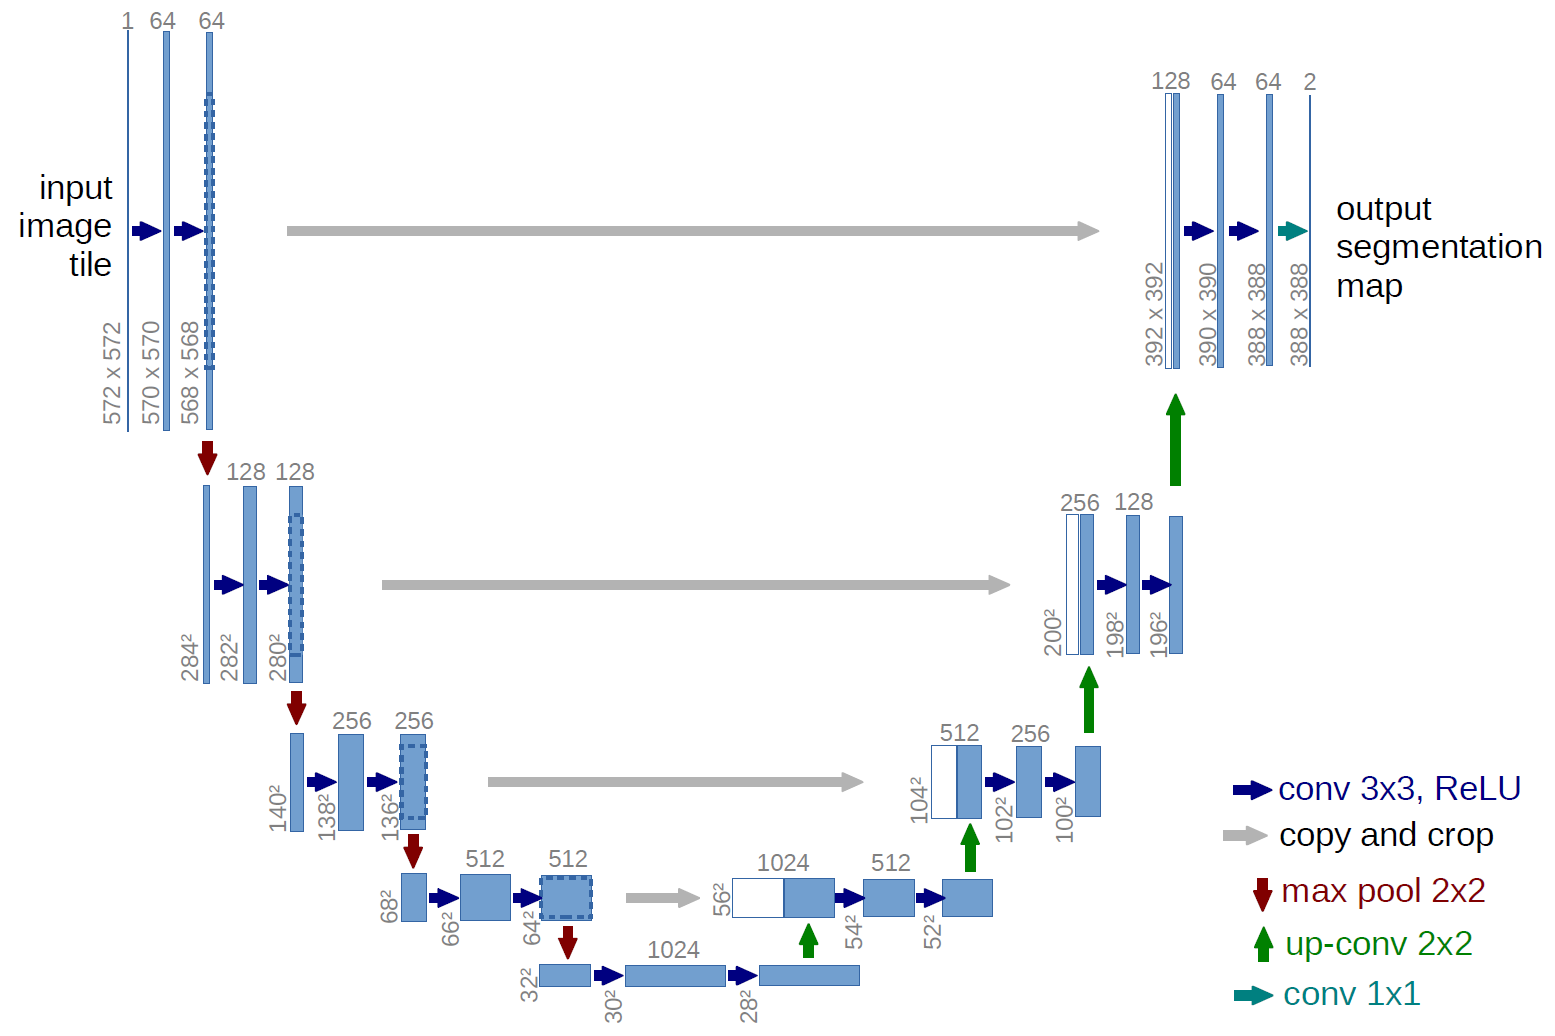

Tal y como se realiza en el [**video**](https://www.youtube.com/watch?v=5Qm2TQRtn9A.), hemos definido cada una de las capas necesarias para completar nuestra red U-net. Hemos definido una función conv3x3_bn que nos realizará una convolución seguido de un BatchNorm para normalizar los datos de entrada de una capa antes de ser procesados por la capa siguiente y una llamada a la función ReLu para agregar no linealidad a las operaciones de la red, este proceso equivale a las flechas azul marino de la imagen de la arquitectura.
La función encoder_conv que equivale al paso de aplicar la flecha roja de nuestra imagen de la arquitectura, esta función realizará un MaxPool que nos dividirá por la mitad el tamaño del mapa de características, seguido de dos llamadas a conv3x3, esto es precisamente la operación que realiza la red U-net de forma iterativa hasta finalizar la parte del encoder. Esta parte de la arquitectura se dedica a extraer patrones de la imagen de entrada, como formas bordes etc.

Durante la etapa del decoder, realizaremos un proceso similar al anterior, pero en este caso en lugar de ir reduciendo el tamaño del mapa de características lo iremos aumentando. Si durante el encoder hemos ido reduciendo el tamaño a la mitad, durante el decoder iremos multiplicando al doble, para ello hacemos uso de la función ConvTranspose2d seguida de dos llamadas a conv3x3_bn que ya hemos usado durante la etapa del encoder. Durante el proceso de decoder, hay que tener en cuenta que vamos a concatenar las salidas obtenidas anteriormente en el encoder, con las salidas que estemos obteniendo ahora. A la salida de la red lo que obtendremos será un mapa de características del mismo tamaño que la entrada original, usando la función sigmoid conseguimos que cada uno de los valores contenidos en el mapa de características se encuentre entre 0 y 1, este valor determinará si es fondo o si es célula, y nos permitirá compararlos con la máscara que está preparada en formato one-hot encoding precisamente para que podamos realizar esas comparaciones.
Durante este etapa aprovechamos las características obtenidas en la etapa anterior, mientras vamos aumentando la resolución de la imagen, para llegar al resultado final que es la imagen segmentada.


In [ ]:
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=2, in_ch=3):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)

        return x

# NET

La arquitectura de esta red se ha obtenido del siguiente **[paper](https://www.researchgate.net/publication/343691111_Efficient_identification_localization_and_quantification_of_grapevine_inflorescences_and_flowers_in_unprepared_field_images_using_Fully_Convolutional_Networks#pf4)**, por lo tanto, la arquitectura es:

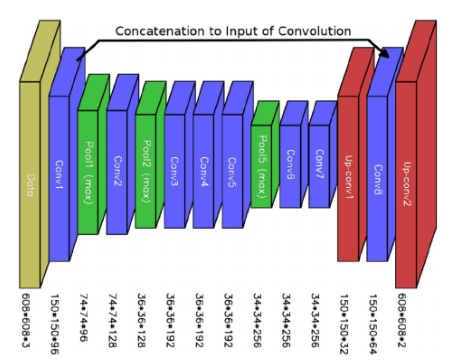

Como se puede ver, las imágenes de input tienen unas dimensiones iniciales de 608 x 608 x 3.
La arquitectura consta de una serie de capas de convoluciones y pooling que codifican sucesivamente la imagen de entrada en representaciones de características cada vez más complejas y abstractas. La arquitectura también incluye capas de up-sampling que nos sirven para aumentar la resolución, las representaciones de características a la resolución original de la imagen(608 x 608), obteniendo así las etiquetas de clase para todos los píxeles. También hay una concatenación entre la salida de la primera convolución(**Conv1**) con la primera capa de Up-Sample, esta concatenación nos permite combinar las características de una primera capa, cuyos resultados se podría decir que son poco abstractos con las características de mayor abstracción, esta combinación puede mejorar el rendimiento y la precisión de la red. Se ha eliminado la capa de softmax, pues esta es buena para clasificación, pero no para segmentación, ya que no nos permite generar un mapa de probabilidades para cada pixel. Aunque no esté representado en el esquema, después de cada convolución se aplica una ReLu, eliminando así información que no aporta nada, mejorando la red.

Finalmente, en el **[paper](https://www.researchgate.net/publication/343691111_Efficient_identification_localization_and_quantification_of_grapevine_inflorescences_and_flowers_in_unprepared_field_images_using_Fully_Convolutional_Networks#pf4)** se nos indica el tamaño del filtro, pero el padding y el stride solo están definidas para ciertas capas, así que en las que no estaban definidas se han tenido que calcular.

In [ ]:
# Definimos la red como una clase que hereda de nn.Module
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Añadimos la primera capa de convolución
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=(11, 11), stride=4)
      
        # Añadimos la primera capa de pooling
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)

        # Añadimos la segunda capa de convolución
        self.conv2 = nn.Conv2d(96, 128, kernel_size=(5, 5), stride=1, padding=2)

        # Añadimos la segunda capa de pooling
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=0)

        # Añadimos la tercera, cuarta y quinta capa de convolución
        self.conv3 = nn.Conv2d(128, 192, kernel_size=(3, 3), stride=1, padding=1)
        self.conv4 = nn.Conv2d(192, 192, kernel_size=(3, 3), stride=1, padding=1)
        self.conv5 = nn.Conv2d(192, 192, kernel_size=(3, 3), stride=1, padding=1)

        # Añadimos la quinta capa de pooling
        self.pool5 = nn.MaxPool2d(kernel_size=(3, 3), stride=1, padding=0)

        # Añadimos la sexta y séptima capa de convolución
        self.conv6 = nn.Conv2d(192, 256, kernel_size=(3, 3), stride=1, padding=1)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=1, padding=1)

        # Añadimos la primera capa de up-convolución
        self.upconv1 = nn.ConvTranspose2d(256, 32, kernel_size=(14, 14), stride=4, padding=0)
        
        # Añadimos la octava capa de convolución
        self.conv8 = nn.Conv2d(128, 64, kernel_size=(3, 3), stride=1, padding=1)

        # Añadimos la segunda capa de up-convolución
        self.upconv2 = nn.ConvTranspose2d(64, 2, kernel_size=(12, 12), stride=4, padding=0)

    def forward(self, x):
        # Aplicamos la primera capa de convolución y pooling
        x_aux = self.conv1(x)
        x = self.relu(x)
        x_aux2 = self.pool1(x_aux)
        # Aplicamos la segunda capa de convolución y pooling
        x = self.conv2(x_aux2)
        x = self.relu(x)
        x = self.pool2(x)
        # Aplicamos la tercera, cuarta y quinta capa de convolución y pooling
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.pool5(x)
        # Aplicamos la sexta y séptima capa de convolución
        x = self.conv6(x)
        x = self.relu(x)
        x = self.conv7(x)
        x = self.relu(x)
        # Aplicamos la primera capa de up-convolución
        x = self.upconv1(x)
        # Concatenamos las salidas de Conv1 y Up-conv1
        x = torch.cat((x_aux, x), dim=1)
        # Aplicamos la octava capa de convolución
        x = self.conv8(x)
        x = self.relu(x)
        # Aplicamos la segunda capa de up-convolución
        x = self.upconv2(x)
        return x

# Métrica

Como métrica del entrenamiento usaremos ***Intersection Over Union*** , hemos elegido esta porque nos permite medir la similitud entre dos regiones, una región es la segmentada por la red y la otra será la imagen original.

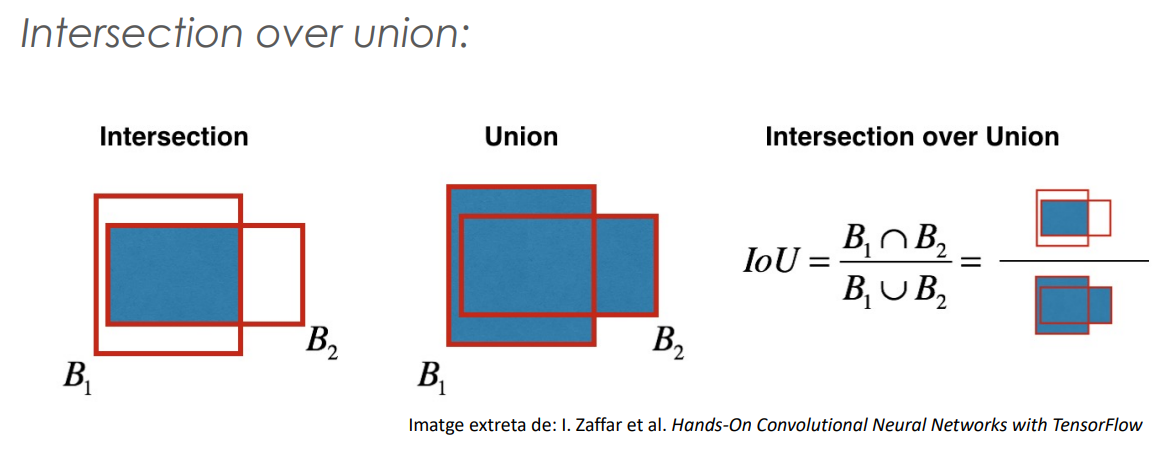

Esta métrica tiene en cuenta tanto la proporción de pixeles segmentados correctamente, como la proporción de pixeles verdaderos que fueron segmentados.

Su valor oscila entre 0 y 1, siendo 1 una segmentación perfecta, esto es otra ventaja, pues es una medida es facil de interpretar.

In [ ]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    # Definimos Smooth para evitar divisiones por 0.
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        # Se calcula la intersección y se suman para obtener un valor escalar
        intersection = (_out & _labs).float().sum((1, 2))
        # Se calcula la union y se suman para obtener un valor escalar
        union = (_out | _labs).float().sum((1, 2))
        # Se calcula la division de i/u, sumandole smooth.
        iou = (intersection + SMOOTH) / (union + SMOOTH)
        ious.append(iou.mean().item())
    return np.mean(ious)

# Entrenamiento

Para evaluar el rendimiento del modelo, utilizamos varias muestras para entrenarlo. Es importante seleccionar una buena función de pérdida para optimizar el rendimiento del modelo. En nuestro caso, hemos seleccionado la función de pérdida BCEWithLogitsLoss, ya que es adecuada para tareas de clasificación binaria. Esta función aplica una función de activación sigmoid a las salidas de la red, para asegurar que los valores de las salidas se encuentren entre 0 y 1. Luego, calcula la entropía cruzada binaria, que es una medida de la diferencia entre la distribución de probabilidad prevista y la distribución de probabilidad real. Utilizando esta función de pérdida, podemos ajustar los parámetros de la red para minimizar la diferencia entre las salidas previstas y las salidas reales y mejorar el rendimiento del modelo en la tarea de segmentación de imágenes.

In [ ]:
from tqdm import tqdm

def fit(model, dataloader, epochs, imgs, masks,lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

Ahora vamos a entrenar la red **Net** con **100 epochs**.

Si no se quiere entrenar la red y solo se quiere cargar los pesos, hay que descomentar la línea de código comentado, y comentar la última línea.

In [ ]:
modelNet = Net()
#modelNET.load_state_dict(torch.load('./pesosNET.pth'))
histNet = fit(modelNet, dataloaderNet, epochs=100,imgs=imgsNet,masks=masksNet)

Podemos ver como en la última época obtenemos un **iou** de más o menos **0.9**, lo cual es un resultado muy bueno, ya que como hemos explicado antes, 1 es segmentación perfecta y nuestro resultado es cercano a este valor.

Ahora vamos a entrenar la red **UNet** con **100 epochs**.

Si no se quiere entrenar la red y solo se quiere cargar los pesos, hay que descomentar la línea de código comentado, y comentar la última línea.

In [ ]:
modelUNET = UNet()
#modelUNET.load_state_dict(torch.load('./pesosUNET.pth'))
histUNET = fit(modelUNET, dataloaderUNET,epochs=100,imgs=imgsUNET,masks=masksUNET)

Podemos ver como en la última época obtenemos un **iou** de más o menos **0.95**, lo cual es un resultado casi perfecto.

# Gráficos de resultado

El siguiente código muestra el gráfico del entrenamiento, cabe añadir que este código solo se puede ejecutar si se ha entrenado el modelo, en caso de cargar los pesos no se puede ejecutar y, por lo tanto, hay que comentarlo u omitirlo. Para solucionar esto se proporcionará una imagen de los gráficos para que se puedan ver correctamente en esa situación.


## Gráfico UNET

In [ ]:
df=pd.DataFrame(histUNET)
df.plot(grid=True)
plt.show()

En este gráfico se puede ver como test_iou e iou, aumentan mientras que test_loss y loss disminuyen. Esto significa que el modelo mejora su capacidad de predicción correctamente a medida que pasan las epocas. Además con la disminución de test_loss y loss , se puede ver que el modelo aprende de forma eficaz sin sufrir de overfitting.

El hecho de que test_iou comience en 0 y suba rápidamente a 0.8 sugiere que el modelo tiene un buen desempeño en los datos de prueba desde el principio y mejora a medida que se entrena.

La siguiente imagen muestra el gráfico mostrado anteriormente por si se hace la carga de pesos y no el entrenamiento.

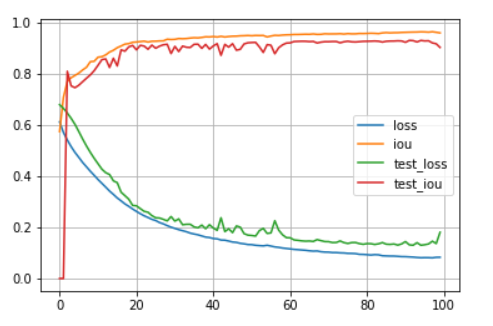

## Gráfico NET

In [ ]:
df=pd.DataFrame(histNet)
df.plot(grid=True)
plt.show()

En este gráfico se puede ver como test_iou e iou, aumentan mientras que test_loss y loss disminuyen. Esto significa que el modelo mejora su capacidad de predicción correctamente a medida que pasan las epocas. Además con la disminución de test_loss y loss , se puede ver que el modelo aprende de forma eficaz sin sufrir de overfitting.

La siguiente imagen muestra el gráfico mostrado anteriormente por si se hace la carga de pesos y no el entrenamiento.

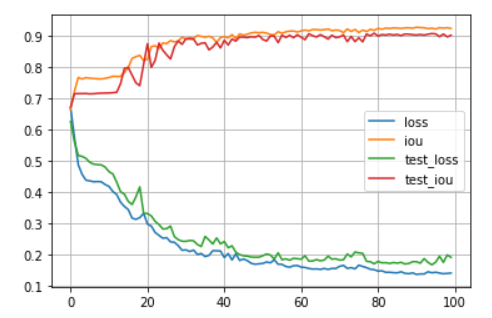

# Resultados

La función **_plot_results** nos permite visualizar el resultado de la segmentación. Se elige una muestra del dataset de test y se le añade una dimensión usando **[unsqueeze](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html)**, la salida se pasa a través de **[torch.argmax](https://pytorch.org/docs/stable/generated/torch.argmax.html)** con el eje 0 para obtener la clase con la probabilidad máxima en cada pixel.

Una vez hecho esto mostramos tres imágenes:

- Imagen original
- Máscara original
- Mascará predicha

In [ ]:
import random
def _plot_results(model,dataset):
  model.eval()
  with torch.no_grad():
      ix = random.randint(0, len(dataset['test'])-1)
      img, mask = dataset['test'][ix]
      output = model(img.unsqueeze(0).to(device))[0]
      pred_mask = torch.argmax(output, axis=0)
 
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
  img = img.permute(1,2,0)
  ax1.imshow(img.squeeze(0))
  ax2.imshow(torch.argmax(mask, axis=0))
  ax3.imshow(pred_mask.squeeze().cpu().numpy())
  ax1.title.set_text('IMAGEN')
  ax2.title.set_text('MASK')
  ax3.title.set_text('MASK_PRED')
  plt.show()


## Resultados UNET

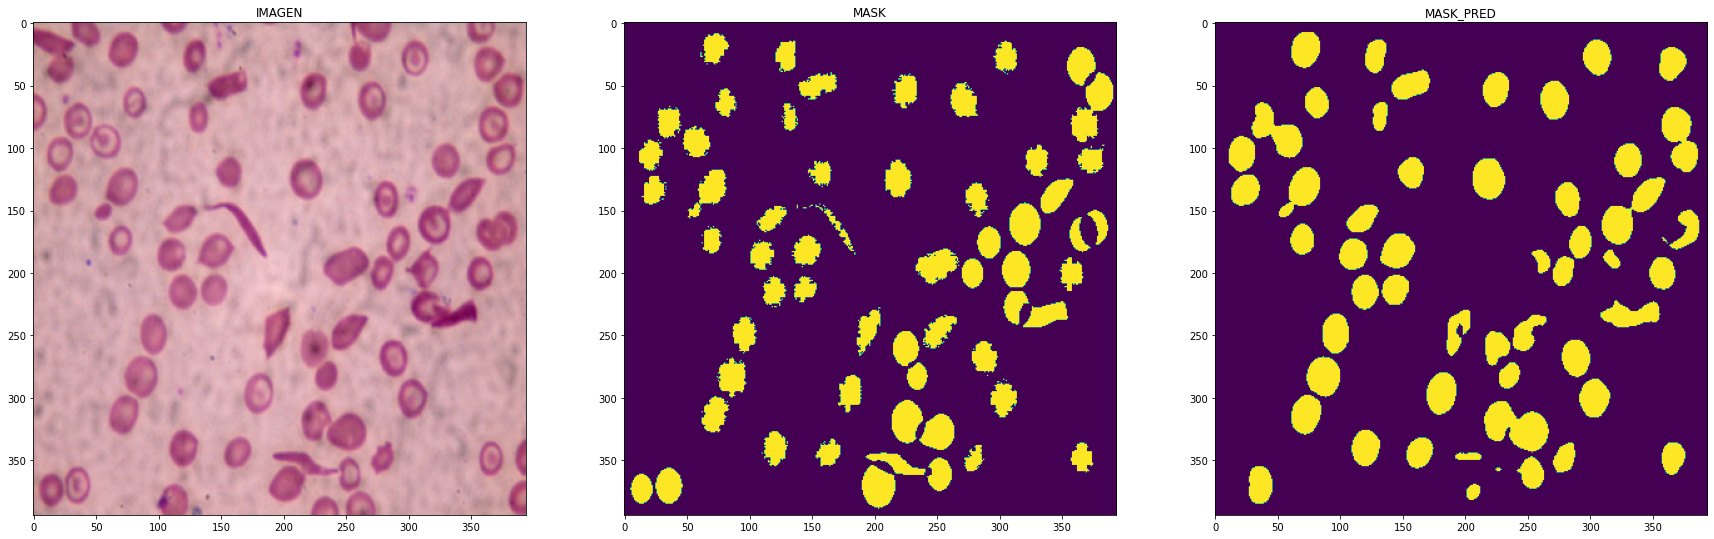

In [ ]:
_plot_results(modelUNET,datasetUNET)

Se puede ver como la mascara predicha es casi identica a la mascara original, y las pocas diferencias que se encuentran son muy leves. Lo que nos demuestra que la red ha hecho bien su trabajo.

## Resultados NET

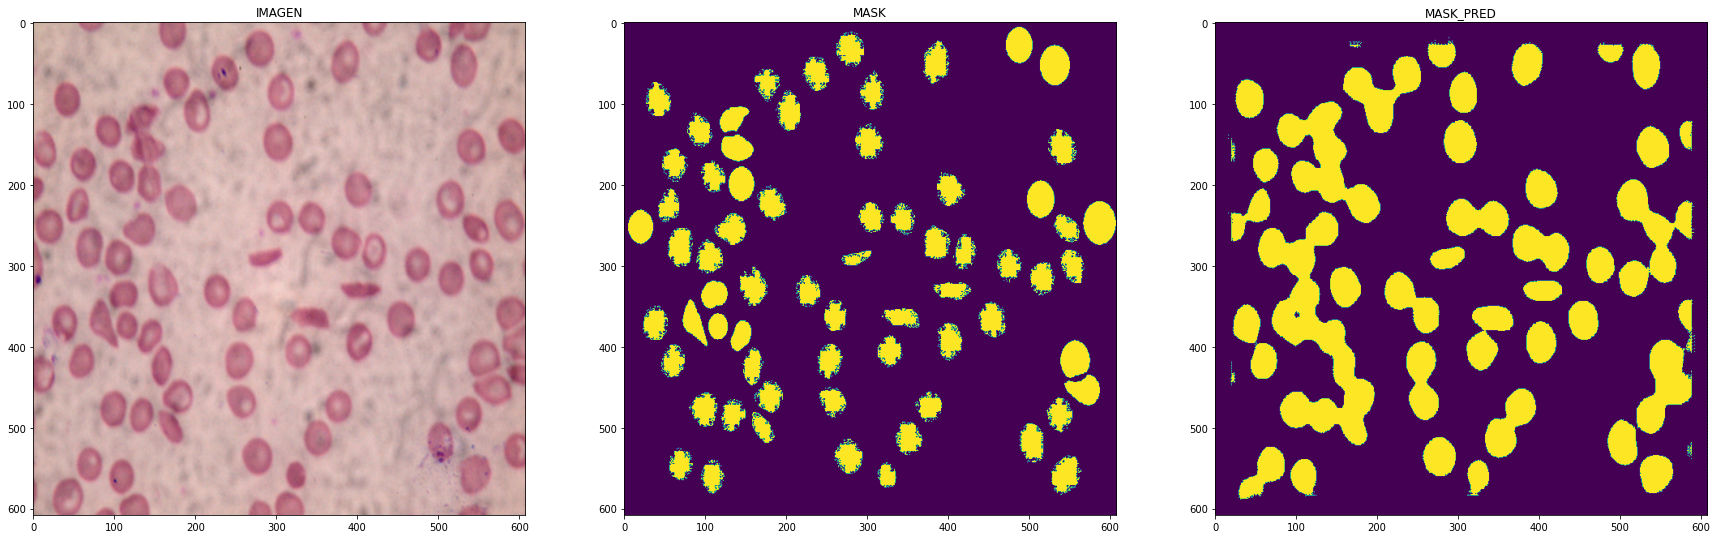

In [ ]:
_plot_results(modelNet,datasetNet)

En este resultado se puede ver como la imagen que se genera es parecida a la máscara original, aunque no es perfecta, ya que lo que vendría a ser la “forma” o “distribución” de la imagen, si está bien predicha, falla en la separación de las células, porque hay bastantes que las cuenta como una sola en una célula grande, cuando en realidad hay una ligera separación entre estas.

# Guardar pesos

El siguiente codigo es para guardar los pesos del entrenamiento en un fichero, cabe añadir que este codigo solo es necesario ejecutarlo cuando se realiza el entrenamiento, ya que si no se ha realizado guardaremos en el fichero lo mismoq que ya habia. Para guardrlos hemos usado la función **[torch.save](https://pytorch.org/docs/stable/generated/torch.save.html)** junto con el diccionario **[state_dict](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html)** del modelo.

In [ ]:
# Guardar pesos de la red NET

model_path = './pesosNET.pth'
torch.save(modelNet.state_dict(), model_path)

In [ ]:
# Guardar pesos de la red UNET

model_path = './pesosUNET.pth'
torch.save(modelUNET.state_dict(), model_path)

# Conclusión

En conclusión, hemos logrado desarrollar un modelo de segmentación de imágenes de células bastante eficaz.

Uno de los puntos clave de nuestro proyecto ha sido el uso del paper en el que nos hemos inspirado, el cual abordaba un problema similar: la segmentación de racimos de uvas. Aunque el objeto a segmentar era diferente, ambos son circulares, lo que nos ha permitido aplicar los mismos principios y técnicas para resolver nuestro problema de segmentación de células. También ha sido importante el uso de diferentes videos para comprender la arquitectura de la UNET.

En general, nuestro proyecto ha sido una excelente oportunidad para aplicar los conocimientos teóricos y ha sido muy útil para comprender mejor el funcionamiento de las redes convolucionales.